# **Regression**

> ❗ **Recall**

> Estimating the amount of crop production is a **regression** task since crop `Production` quantity is a continuous variable that takes on an infinate number of possible values


## Load and clean the data
> We'll load and clean the data the same way we did in the previous notebook during Exploratory Data Analysis (EDA)

> ✋ **Recall**

> Also, during the EDA phase, we concluded we'll model using the following columns: `Crop`, `Season`, `State`, `Area`, `Fertilizer`, `Pesticide`
+ The `usecols` parameter of the [`pandas.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) method allows us to explicitly specify what columns we want included

In [75]:
# import pandas, matplotlib, seaborn
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# specify stylesheet
plt.style.use('fast')

In [2]:
# load the dataset into a pandas DataFrame object, but only for the needed columns
crops = pd.read_csv('/content/crop_yields.csv',
    usecols=['Crop', 'Season', 'State', 'Area', 'Fertilizer', 'Pesticide', 'Production'])

# dataset info
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Crop        19689 non-null  object 
 1   Season      19689 non-null  object 
 2   State       19689 non-null  object 
 3   Area        19689 non-null  float64
 4   Production  19689 non-null  int64  
 5   Fertilizer  19689 non-null  float64
 6   Pesticide   19689 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.1+ MB


In [3]:
# re-arrange the columns to have the Production column at the end
crop_cols = crops.columns.to_list()
crop_cols.pop(crops.columns.get_loc('Production'))
crop_cols.append('Production')
crops = crops[crop_cols]

### Numeric & categorical columns
> Distinguish _numeric_ & _categorical_ columns
+ Use [`DataFrame.select_dtypes()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) to return a subset of the DataFrame’s columns based on the column dtypes
+ Then return the column names and turn those into a `list`
+ Here, [`DataFrame.iloc[]`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) is used to select all rows, from column `0` to second-last

In [4]:
# numeric
num_cols = crops.iloc[:, 0 :-1].select_dtypes(include='number')\
                              .columns.to_list()
num_cols

['Area', 'Fertilizer', 'Pesticide']

In [5]:
# categorical
cat_cols = crops.select_dtypes(include='object').columns.to_list()
cat_cols

['Crop', 'Season', 'State']

In [6]:
# get index of categorical columns in DataFrame
cat_cols_indices = [crops.columns.get_loc(x) for x in cat_cols]
cat_cols_indices

[0, 1, 2]

In [7]:
# get index of numerical columns in DataFrame
num_cols_indices = [crops.columns.get_loc(x) for x in num_cols]
num_cols_indices

[3, 4, 5]

In [8]:
# remove leading & trailing whitespaces from categorical values
for col in cat_cols:
  crops[col] = crops[col].apply(lambda x: x.strip())

### Filter out unwanted rows (based on categorical features)
> 💡 **Info**

> Recall, that all [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/frame.html) columns can be accessed as [`pandas.Series`](https://pandas.pydata.org/docs/reference/series.html) objects
+ [`pandas.Series.nunique()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.nunique.html) - Returns number of unique elements in the _column_
+ [`pandas.Series.unique()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) - Returns unique values in the _column_

In [9]:
# loop through each categorical feature
for col in cat_cols:
  print(f'No. of {col}s: {crops[col].nunique()}')
  print(f'Unique {col}s:\n{crops[col].unique()}\n\n-------------------')

No. of Crops: 55
Unique Crops:
['Arecanut' 'Arhar/Tur' 'Castor seed' 'Coconut' 'Cotton(lint)'
 'Dry chillies' 'Gram' 'Jute' 'Linseed' 'Maize' 'Mesta' 'Niger seed'
 'Onion' 'Other  Rabi pulses' 'Potato' 'Rapeseed &Mustard' 'Rice'
 'Sesamum' 'Small millets' 'Sugarcane' 'Sweet potato' 'Tapioca' 'Tobacco'
 'Turmeric' 'Wheat' 'Bajra' 'Black pepper' 'Cardamom' 'Coriander' 'Garlic'
 'Ginger' 'Groundnut' 'Horse-gram' 'Jowar' 'Ragi' 'Cashewnut' 'Banana'
 'Soyabean' 'Barley' 'Khesari' 'Masoor' 'Moong(Green Gram)'
 'Other Kharif pulses' 'Safflower' 'Sannhamp' 'Sunflower' 'Urad'
 'Peas & beans (Pulses)' 'other oilseeds' 'Other Cereals' 'Cowpea(Lobia)'
 'Oilseeds total' 'Guar seed' 'Other Summer Pulses' 'Moth']

-------------------
No. of Seasons: 6
Unique Seasons:
['Whole Year' 'Kharif' 'Rabi' 'Autumn' 'Summer' 'Winter']

-------------------
No. of States: 30
Unique States:
['Assam' 'Karnataka' 'Kerala' 'Meghalaya' 'West Bengal' 'Puducherry' 'Goa'
 'Andhra Pradesh' 'Tamil Nadu' 'Odisha' 'Bihar' 'G

> 👀 **Observation**

> The `Season` & `State` columns are okay, but the `Crop` column has crops that have been _grouped_. In particular, these are `other oilseeds`, `Other Cereals`, `Oilseeds total`, `Rapeseed &Mustard`, `Other Summer Pulses`, `Other Kharif pulses`, `Peas & beans (Pulses)`, & `Other  Rabi pulses`

> Since we want out model to make predictions from distinct crop types and not _grouped_ crops, we'll filter out these rows
+ To achieve, this we'll use the [`Series.isin(values)`](https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html#pandas.Series.isin) which returns a boolean `Series` mask showing whether each element in the `Series` (column in this case) matches an element in the passed sequence of `values` exactly
+ We can then invert the mask using the squiggley sign, `~` to filter out those specific rows
+ Not that it has any effect, but I'll reorder the `index` of the final `DataFrame` using [`DataFrame.reset_index()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html)

In [10]:
# list containing grouped crop names
grouped_crops = ['other oilseeds', 'Other Cereals', 'Oilseeds total',
                 'Rapeseed &Mustard','Other Summer Pulses', 'Other Kharif pulses',
                 'Peas & beans (Pulses)', 'Other  Rabi pulses']

# mask to select rows that have any of the grouped crop names
mask = crops['Crop'].isin(grouped_crops)

# filter those rows out (using ~ before the mask)
crops = crops[~mask].reset_index(drop=True)

### Remove outliers from all numerical columns
> We'll do that using the helper function below, although it will significantly reduce the size of the data

In [11]:
'''
  define a function that removes outliers for all numeric
    in a DataFrame
'''
def remove_df_outliers(dataframe):
  df = dataframe.copy()

  # get numeric columns
  numeric_columns = df.select_dtypes(include='number').columns

  # loop through all numeric columns
  for col in numeric_columns:
    # define upper and lower limits
    lower_limit = df[col].quantile(0.05)
    upper_limit = df[col].quantile(0.95)

    # filter dataframe based on limits
    df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

  return df

In [12]:
# remove outliers
crops = remove_df_outliers(crops)

### Check for `Null` values
> The dataset doesn't seem to have null values, but we can still check
+ The [`DataFrame.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull) return a boolean same-sized object indicating if the values are NA
+ The `sum()` method sums all `Null` instances per column and returns a summary

In [117]:
# check for null values per column
crops.isnull().sum().to_dict()

{'Crop': 0,
 'Season': 0,
 'State': 0,
 'Area': 0,
 'Fertilizer': 0,
 'Pesticide': 0,
 'Production': 0}

> 📈 **Observation**

> Zero `Null` values in the columns. So we're good.

### Descriptive statistics of _numeric_ columns
+ Generate a summary of dataset's descriptive statistics of _numerical_ columns using [`DataFrame.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) method
+ Descriptive statistics include summary of central tendency, dispersion and shape of a dataset’s distribution

In [14]:
# generate a summary of dataset's descriptive statistics
crops.describe()

,Area,Fertilizer,Pesticide,Production
count,11646.000000,1.164600e+04,11646.000000,11646.000000
mean,35895.319491,4.766527e+06,9244.855108,63131.660914
std,55909.553871,7.459579e+06,13984.726498,116618.805341
min,246.000000,3.131093e+04,91.000000,450.000000
25%,2937.000000,3.929981e+05,766.785000,3429.000000
50%,10105.500000,1.343323e+06,2623.850000,16420.000000
75%,43603.000000,5.822430e+06,11188.362500,64203.750000
max,368230.000000,5.191222e+07,68790.050000,753194.000000


In [15]:
# one last look at the final dataframe info
crops.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11646 entries, 0 to 17740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Crop        11646 non-null  object 
 1   Season      11646 non-null  object 
 2   State       11646 non-null  object 
 3   Area        11646 non-null  float64
 4   Fertilizer  11646 non-null  float64
 5   Pesticide   11646 non-null  float64
 6   Production  11646 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 727.9+ KB


> 💡 **So far**  
+ The dataset has `11646` rows and `7` columns (`6` of which are features), and has no missing values
+ _Categorical_ features are `Crop`, `Season`and `State` whereas numeric columns are `Area`,	`Fertilizer` and `Pesticide`

## Prepare the data for modelling
+ Split the data into features _(x values)_ and target _(y value)_
+ Split the data into training and testing sets

### Features & target
+ The [`DataFrame.drop()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html#pandas-dataframe-drop) method is used to drop specified labels from rows or columns.

In [16]:
# label
y = crops['Production'].values

# features
X = crops.drop(columns='Production').values

In [17]:
# shape of X & y
X.shape, y.shape

((11646, 6), (11646,))

### Training and testing sets
+ [`sklearn`](https://scikit-learn.org/stable/index.html) [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method splits matrices into random train and test subsets

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                    test_size=0.3, random_state=42)

In [19]:
# shape of training set
X_train.shape, y_train.shape

((8152, 6), (8152,))

In [20]:
# shape of testing set
X_test.shape, y_test.shape

((3494, 6), (3494,))

## Data preprocessing `pipeline`
> Here, we'll make a data pre-processing pipeline using [`scikit-learn's`](https://scikit-learn.org/stable/index.html) [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) and [`make_colum_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
+ Other classes we'll use are [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#simpleimputer) to handle missing values, [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to _scale_ numerical features and [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to _encode_ categorical features

In [21]:
# imports necessary classes
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import PowerTransformer

In [22]:
# numeric transformer
num_transformer = make_pipeline(
    # transformers
    SimpleImputer(strategy='median'), # 1. handle missing values if any
    PowerTransformer(), # transform into Gaussian like ditribution
    StandardScaler() # 3. scale
)

# categorical transformer
cat_transformer = make_pipeline(
    # transformers
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# wrap the above transformers into a preprocessor
preprocessor = make_column_transformer(
    #(transformer, columns)
    (num_transformer, num_cols_indices),
    (cat_transformer, cat_cols_indices)
)

## Hyperparameter Optimization with [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html)  
> 📝 **Note**  
> [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
+ I covered `Optuna` in a previous repository linked [`here`](https://github.com/Martinmbiro/Train-and-evaluate-regression-models)

> 🔤 **Optuna Optimization Process**  
+ Define an `objective` function (within which you invoke suggest methods of a [`Trial`](https://optuna.readthedocs.io/en/stable/reference/trial.html) object to generate hyperparameters)
+ Create a [`study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) and specify the `direction` of optimization
+ `optimize` the `objective` function by specifying the number of [`trials`](https://optuna.readthedocs.io/en/stable/reference/trial.html)

#### Install and import libraries

In [ ]:
# install optuna, xgboost, optuna-integration
!pip install optuna xgboost optuna-integration

In [24]:
import warnings
# import optuna
import optuna
# adjust verbosity of optuna study:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# catboost callback to prune unpromising trials
from optuna.integration import XGBoostPruningCallback
# suppress experimental warnings for CatBoostPruningCallaback
warnings.filterwarnings('ignore',
                        category=optuna.exceptions.ExperimentalWarning)

# import XGBRegressor
from xgboost import XGBRegressor

# kfold, cross_val_score
from sklearn.model_selection import KFold, cross_val_score

# metrics
from sklearn.pipeline import Pipeline

# import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

In [25]:
# preprocessed X_test
X_test_processed = preprocessor.fit_transform(X_test)
# preprocessed X_train
X_train_processed = preprocessor.fit_transform(X_train)

### Tuning `XGBRegressor`

#### Define `objective` function
+ List of `xgboost` parametes to be tuned can be found on their documentation [`here`](https://xgboost.readthedocs.io/en/stable/parameter.html)
+ A brief guide on parameter tuning with `xgboost` can be found in their documentation [`here`](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html)

In [ ]:
def objective(trial):
  params = {
    'n_estimators': 1000,
    'early_stopping_rounds': 20,
    'eval_metric': 'mae',
    'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
    'reg_lambda': trial.suggest_int('reg_lambda', 3, 10),
    'max_depth': trial.suggest_int('max_depth', 4, 10),
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
  }

  # callback
  call = XGBoostPruningCallback(trial, 'validation_0-mae')

  # xgbregressor with params
  xgb_pipe = Pipeline(steps=[
      #(name of step, estimator)
      ('preprocess', preprocessor),
      ('xgbr', XGBRegressor(**params,
                            callbacks=[call],
                            random_state=42))
  ])

  # KFold object
  kf = KFold(n_splits=3, shuffle=True, random_state=42)

  pass_to_fit = {
      'xgbr__eval_set': [(X_test_processed, y_test)],
      'xgbr__verbose': False,
  }

  '''
    Perform cross validation with the parameters chosen, then return
      the list of metrics gotten from cross validation'''
  scores = cross_val_score(estimator=xgb_pipe, X=X_train, y=y_train,
                           scoring='neg_mean_absolute_error',
                           cv=kf, n_jobs=-1, verbose=0,
                           fit_params=pass_to_fit)

  return scores.mean()

#### Create [`study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) and `optimize` objective function

##### Create [`study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study)
+ By calling [`optuna.create_study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html#optuna.create_study)

In [ ]:
'''
  create a study, and since a lower Root Mean Squared Error (rmse) is better,
    set direction to minimize
'''

study = optuna.create_study(direction='maximize')

##### Optimize `objective` function
+ Optimize an `objective` function by calling [`Study.optimize`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize) function

In [ ]:
%%time
study.optimize(objective, n_trials=10)

CPU times: user 4.09 s, sys: 647 ms, total: 4.74 s
Wall time: 7min 10s


In [ ]:
# return parameters of best study
best_xgb = study.best_params # dict

# print
print(f'Best mae score: {study.best_value}\n\nBest Parameters:')
print('----------------')

for key, val in best_xgb.items():
  print(f'{key} : {val}')

Best mae score: -16726.098574822357

Best Parameters:
----------------
learning_rate : 0.053667368542774145
reg_lambda : 4
max_depth : 5
min_child_weight : 6
subsample : 0.9114954045350141
colsample_bytree : 0.5005621288079357


### Tuning [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#randomforestregressor)

In [ ]:
# define objective function
def objective(trial):
  params = {
    'n_estimators':500,
    'random_state': 42,
    #'max_features': trial.suggest_float('max_features', 0.5, 1.0),
    'max_depth': trial.suggest_int('max_depth', 1, 10),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
  }

  # pipeline + model
  estimator = Pipeline(steps=[
      # (name, transformer)
      ('preprocessor', preprocessor),
      ('rfr', RandomForestRegressor(**params))
  ])

  # KFold object
  kf = KFold(shuffle=True, n_splits=3, random_state=42)

  scores = cross_val_score(estimator, X=X_train, y=y_train,
                          scoring='neg_mean_absolute_error',
                          cv=kf, n_jobs=-1, verbose=0)

  return scores.mean()

In [ ]:
%%time
# create study and optimize objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# get best parameters
best_rf = study.best_params # dict

# print
print(f'Best mae score: {study.best_value}\n\nBest Parameters:')
print('----------------')

for key, val in best_rf.items():
  print(f'{key} : {val}')

Best mae score: -25730.990184934595

Best Parameters:
----------------
max_depth : 10
min_samples_split : 11
min_samples_leaf : 1
CPU times: user 11 s, sys: 1.77 s, total: 12.8 s
Wall time: 15min 29s


## Modelling
> We'll be using the [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) from the [`xgboost`](https://xgboost.readthedocs.io/en/stable/index.html) library and [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#randomforestregressor) from the [`scikit-learn`](https://scikit-learn.org/stable/index.html) library


#### Training tuned `XGBRegressor`
> We'll set an overfitting detector using `XGBRegressor` `early_stopping_rounds` & `eval_metric` parameters, then we'll pass an `eval_set` to the `fit` method during training

In [ ]:
%%time
# pipeline with preprocessor & xgbregressor + tuned parameters
xgbr_model = Pipeline(steps=[
    #(name of step, estimator)
    ('preprocessor', preprocessor),
    ('xgbr', XGBRegressor(**best_xgb,
                  random_state=42,
                  n_estimators=5500,
                  early_stopping_rounds=100,
                  eval_metric='mae'))
])

# train the model
xgbr_model.fit(X_train, y_train,
               xgbr__verbose=300,
               xgbr__eval_set=[(X_train_processed, y_train), # training set
                                (X_test_processed, y_test)]) # evaluation set

print('\n')
print(f'Best Iteration: {xgbr_model.named_steps["xgbr"].best_iteration}')
print(f'Best Score: {xgbr_model.named_steps["xgbr"].best_score}')

[0]	validation_0-mae:71035.77533	validation_1-mae:69810.22139
[300]	validation_0-mae:16488.89563	validation_1-mae:19053.49376
[600]	validation_0-mae:12566.21576	validation_1-mae:16109.09386
[900]	validation_0-mae:10834.58372	validation_1-mae:14990.06500
[1200]	validation_0-mae:9773.25831	validation_1-mae:14466.62436
[1500]	validation_0-mae:8967.12191	validation_1-mae:14056.22824
[1800]	validation_0-mae:8371.91227	validation_1-mae:13895.02490
[2100]	validation_0-mae:7900.52866	validation_1-mae:13788.68469
[2400]	validation_0-mae:7463.65697	validation_1-mae:13689.93363
[2700]	validation_0-mae:7081.36394	validation_1-mae:13610.95899
[3000]	validation_0-mae:6741.74371	validation_1-mae:13533.64422
[3300]	validation_0-mae:6451.68133	validation_1-mae:13489.82371
[3477]	validation_0-mae:6286.45464	validation_1-mae:13483.20701


Best Iteration: 3378
Best Score: 13469.73272188882
CPU times: user 8min 1s, sys: 787 ms, total: 8min 1s
Wall time: 4min 49s


##### Plot the training and evaluation scores
> We can access the evaluation results from the trained model using the [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) method, `evals_result()`
+ Plot training and evaluation scores against number of boosted trees / interations

In [ ]:
# get the keys from the evaluation results dictionary
xgbr_model.named_steps['xgbr'].evals_result().keys()

dict_keys(['validation_0', 'validation_1'])

In [ ]:
# test & eval scores
training_scores = xgbr_model.named_steps['xgbr']\
                        .evals_result()['validation_0']['mae']

eval_scores = xgbr_model.named_steps['xgbr']\
                        .evals_result()['validation_1']['mae']

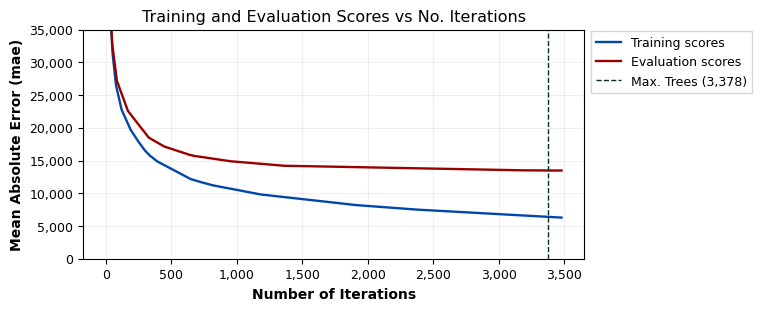

In [ ]:
# specify Axes
_, ax = plt.subplots(figsize=(7.5,3), layout='constrained')

# plot
ax.plot(training_scores, linewidth=1.7, label='Training scores', color='#0047ab')
ax.plot(eval_scores, linewidth=1.7, label='Evaluation scores', color='#990000')

# title, axis labels, grid, legend
ax.set_title('Training and Evaluation Scores vs No. Iterations',
             fontsize=11.5)
ax.set_ylabel('Mean Absolute Error (mae)', weight='black')
ax.set_xlabel('Number of Iterations', weight='black')

# plot a vertical line at the point where maximum trees were achieved
max_trees = xgbr_model.named_steps['xgbr'].best_iteration
ax.axvline(x=max_trees, color='#013220',
          linestyle='--', linewidth=1,
           label=f'Max. Trees ({format(max_trees, ",")})')

# ticks, grid
ax.grid(axis='both', alpha=0.2)
ax.yaxis.set_major_formatter(matplotlib.ticker\
        .FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.ticker\
        .FuncFormatter(lambda x, p: format(int(x), ',')))
ax.tick_params(axis='both', labelsize=9)
ax.set_ylim(0, 35000)

# legend
ax.legend(fontsize=9, fancybox=False, loc='upper left',
          bbox_to_anchor=(1, 1.02))

plt.show()

> 📈 **Insight**  

> Thanks to the `early_stopping` mechanism, the model stopped training at the point of _convergence_ (3,378 trees) where further training would have plateaued the _eval_metric_ `(mean_absolute_error)` or made it worse

### Training `XGBRegressor` model with default parameters

In [26]:
%%time
# pipeline + vanilla XGBRegressor
xgb_model_vanilla = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgbr', XGBRegressor(n_estimators=1000,
                  random_state=72,
                  early_stopping_rounds=100,
                  eval_metric='mae'))
])

# train the model
xgb_model_vanilla.fit(X_train, y_train,
               xgbr__verbose=100,
               xgbr__eval_set=[(X_train_processed, y_train), # training set
                                (X_test_processed, y_test)]) # evaluation set

print('\n')

[0]	validation_0-mae:58475.48379	validation_1-mae:57685.66010
[100]	validation_0-mae:7916.74544	validation_1-mae:13677.49103
[200]	validation_0-mae:4876.00857	validation_1-mae:12909.83049
[300]	validation_0-mae:3373.45099	validation_1-mae:12609.53812
[400]	validation_0-mae:2459.03352	validation_1-mae:12479.36576
[500]	validation_0-mae:1909.90605	validation_1-mae:12467.95605
[540]	validation_0-mae:1708.36314	validation_1-mae:12468.50625


CPU times: user 1min 38s, sys: 252 ms, total: 1min 38s
Wall time: 1min 39s


##### Plot the training and evaluation scores


In [29]:
# view the keys from the eval_result() dictionary
xgb_model_vanilla.named_steps['xgbr'].evals_result().keys()

dict_keys(['validation_0', 'validation_1'])

In [34]:
# test & eval scores
training_scores = xgb_model_vanilla.named_steps['xgbr']\
    .evals_result()['validation_0']['mae']

eval_scores = xgb_model_vanilla.named_steps['xgbr']\
    .evals_result()['validation_1']['mae']

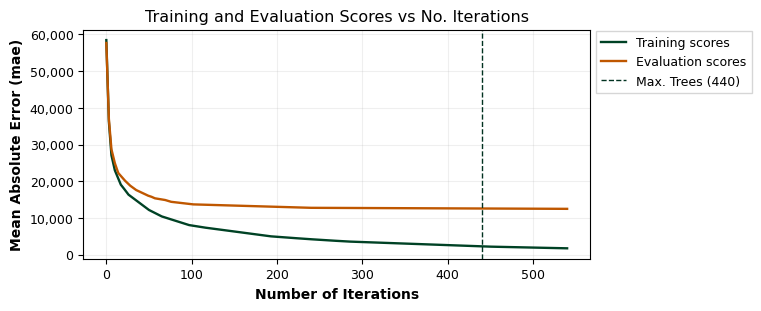

In [113]:
# specify Axes
_, ax = plt.subplots(figsize=(7.5,3), layout='constrained')

# plot
ax.plot(training_scores, linewidth=1.7, label='Training scores', color='#004225')
ax.plot(eval_scores, linewidth=1.7, label='Evaluation scores', color='#bf5700')

# title, axis labels, grid, legend
ax.set_title('Training and Evaluation Scores vs No. Iterations',
             fontsize=11.5)
ax.set_ylabel('Mean Absolute Error (mae)', weight='black')
ax.set_xlabel('Number of Iterations', weight='black')

# plot a vertical line at the point where maximum trees were achieved
max_trees = xgb_model_vanilla.named_steps['xgbr'].best_iteration
ax.axvline(x=max_trees, color='#013220',
          linestyle='--', linewidth=1,
           label=f'Max. Trees ({format(max_trees, ",")})')

# ticks, grid
ax.grid(axis='both', alpha=0.2)
ax.yaxis.set_major_formatter(matplotlib.ticker\
        .FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(matplotlib.ticker\
        .FuncFormatter(lambda x, p: format(int(x), ',')))
ax.tick_params(axis='both', labelsize=9)
#ax.set_ylim(0, 35000)

# legend
ax.legend(fontsize=9, fancybox=False, loc='upper left',
          bbox_to_anchor=(1, 1.02))

plt.show()

> 📈 **Insight**  

> Thanks to the `early_stopping` mechanism specified, the model stopped training at the point of _convergence_ (440 trees) where further training would have plateaued the _eval_metric_ `(mean_absolute_error)` or made it worse

### Training tuned `RandomForestRegressor`

In [ ]:
%%time
# pipeline + RandomForestRegressor + tuned parameters
forest_model = Pipeline(steps=[
    ('preproces', preprocessor),
    ('rfr', RandomForestRegressor(**best_rf,
                                  n_estimators=500,
                                  random_state=42))
])

# train
forest_model.fit(X_train, y_train)
print('\n')



CPU times: user 2min 46s, sys: 228 ms, total: 2min 46s
Wall time: 3min 12s


### Training `RandomForestRegressor` with default parameters

In [36]:
%%time
# pipeline + vanialla RandomForestRegressor
forest_model_vanilla = Pipeline(steps=[
    ('preproces', preprocessor),
    ('rfr', RandomForestRegressor(n_estimators=500,
                                  random_state=42))
])

# train
forest_model_vanilla.fit(X_train, y_train)
print('\n')



CPU times: user 2min 33s, sys: 509 ms, total: 2min 34s
Wall time: 2min 36s


## Evaluation
> Time to see how well the model performed.
+ We'll evauate our _regression_ model using the following metrics: [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score), [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error), [`mean_absolute_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)
>> + `r2_score` is measured on a sclale of `0` - `1.0`, whereas `mean_squared_error` and `mean_absolute_error` should ideally as small as possible
+ Note that there are other metrics to evaluate regression models. Those can be found on the `sklearn` documentation [`here`](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [38]:
# import necessary regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

# define a function to perform evaluation
def evaluate_model(model, X_test, y_test):
  # get predictions
  y_pred = model.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)

  # print
  print(f'R_Squared: {round(r2, 2)}')
  print(f'Mean Squared Error: {format(round(mse, 2), ",")}')
  print(f'Root Mean Squared Error: {format(round(rmse, 2), ",")}')
  print(f'Mean Absolute Error: {format(round(mae, 2), ",")}')

### `XGBRegressor`

In [ ]:
# evaluate tuned XGBRegressor model
evaluate_model(xgbr_model, X_test, y_test)

R_Squared: 0.92
Mean Squared Error: 992,865,445.73
Root Mean Squared Error: 31,509.77
Mean Absolute Error: 12,996.6


In [ ]:
# evaluate XGBRegressor model with default parameters
evaluate_model(xgb_model_vanilla, X_test, y_test)

R_Squared: 0.92
Mean Squared Error: 1,003,002,614.06
Root Mean Squared Error: 31,670.22
Mean Absolute Error: 11,940.18


### `RandomForestRegressor`

In [ ]:
# evaluate tuned RandomForestRegressor model
evaluate_model(forest_model, X_test, y_test)

R_Squared: 0.92
Mean Squared Error: 1,003,002,614.06
Root Mean Squared Error: 31,670.22
Mean Absolute Error: 11,940.18


In [39]:
# evaluate RandomForestRegressor model with default parameters
evaluate_model(forest_model_vanilla, X_test, y_test)

R_Squared: 0.93
Mean Squared Error: 974,426,967.34
Root Mean Squared Error: 31,215.81
Mean Absolute Error: 11,557.52


> 💡 **Insight**  

> All models (tuned or not) seem to have have close to the same performance, indicating that a model is only as good as the data it's trained on. All in all, that is the best we could do with this dataset (except maybe feature engineering, or finding more features, such as `temperature` and `soil type`)

## Model persistence

#### Saving the model
> The model with the best metrics `(forest_model_vanilla)` has been saved in the `model` folder of the current repository as `crop_recommendation_model.pkl`

In [40]:
import joblib
filename = 'production_estimation.pkl'

# dump
joblib.dump(value=forest_model_vanilla,
            filename=filename)

['production_estimation.pkl']

#### Model inferencing example

In [93]:
# load the saved model
model = joblib.load(filename)

# assume we have a list of features: (with 'area' at index 3)
X_new = ['Tapioca', 'Whole Year', 'Karnataka', 1058.0, 104720.84, 253.92]

In [120]:
# predicting production
prod = model.predict(np.array(X_new).reshape(1,6))[0]

print(f'Estimated Production: {round(prod, 2)} Tons')

Estimated Production: 7444.74 Tons


In [121]:
# recall that yield is production / area
yields = model.predict(np.array(X_new).reshape(1,6))[0] / X_new[3]

print(f'Estimated Crop Yield: {round(yields, 2)} Tons/ha')

Estimated Crop Yield: 7.04 Tons/ha
